In [1]:
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from IPython.display import Image, display

ANNOTATIONS_FILE = "annotations.pkl"
IMAGE_PREFIX = "../data/train/images/"

In [2]:
annotations = pd.read_pickle(ANNOTATIONS_FILE)
annotations.head()

,source,chart-type,plot-bb,text,axes,data-series,image
0,generated,scatter,"{'height': 231, 'width': 416, 'x0': 57, 'y0': 65}","[{'id': 0, 'polygon': {'x0': 85, 'x1': 478, 'x...","{'x-axis': {'ticks': [{'id': 9, 'tick_pt': {'x...","[{'x': 1949.4200576738224, 'y': 66.68303958393...",e91e28111e86.jpg
1,generated,vertical_bar,"{'height': 164, 'width': 393, 'x0': 68, 'y0': 37}","[{'id': 0, 'polygon': {'x0': 109, 'x1': 355, '...","{'x-axis': {'ticks': [{'id': 11, 'tick_pt': {'...","[{'x': 'Jordan', 'y': 88.35159235668789}, {'x'...",75c0449f6917.jpg
2,generated,scatter,"{'height': 203, 'width': 409, 'x0': 54, 'y0': 21}","[{'id': 0, 'polygon': {'x0': 113, 'x1': 383, '...","{'x-axis': {'ticks': [{'id': 3, 'tick_pt': {'x...","[{'x': 0.9445463278316278, 'y': 52.13870797394...",66dd2a250237.jpg
3,generated,vertical_bar,"{'height': 165, 'width': 396, 'x0': 89, 'y0': 60}","[{'id': 0, 'polygon': {'x0': 71, 'x1': 465, 'x...","{'x-axis': {'ticks': [{'id': 14, 'tick_pt': {'...","[{'x': 'Cuba', 'y': 75695.38632268383}, {'x': ...",58595c30beab.jpg
4,generated,scatter,"{'height': 165, 'width': 394, 'x0': 79, 'y0': 69}","[{'id': 0, 'polygon': {'x0': 75, 'x1': 461, 'x...","{'x-axis': {'ticks': [{'id': 12, 'tick_pt': {'...","[{'x': 0.8933632249058832, 'y': 5.440194292653...",497a547454d7.jpg


In [3]:
import math

def get_bb_labels(labels):
    x_min, x_max, y_min, y_max = math.inf, -math.inf, math.inf, -math.inf
    for label in labels:
        polygon = label['polygon']
        x_min = min(x_min, polygon['x1'], polygon['x2'], polygon['x3'], polygon['x0'])
        x_max = max(x_max, polygon['x1'], polygon['x2'], polygon['x3'], polygon['x0'])
        y_min = min(y_min, polygon['y1'], polygon['y2'], polygon['y3'], polygon['y0'])
        y_max = max(y_max, polygon['y1'], polygon['y2'], polygon['y3'], polygon['y0'])
    return [x_min, y_min, x_max, y_max]


def get_key_points(row):
    # print(row)
    # print(row['text'])
    x_tick_labels = []
    y_tick_labels = []
    plot_left_start = row['plot-bb']['x0']
    for text in row['text']:
        if text['role'] == 'tick_label':
            if text['polygon']['x2'] < plot_left_start:
                y_tick_labels.append(text)
            else:
                x_tick_labels.append(text)
    return np.array([
        row['plot-bb']['x0'],
        row['plot-bb']['y0'],
        row['plot-bb']['x0'] + row['plot-bb']['width'],
        row['plot-bb']['y0'] + row['plot-bb']['height']
    ] + get_bb_labels(x_tick_labels) + get_bb_labels(y_tick_labels))

annotations['key_points'] = annotations.apply(get_key_points, 1)

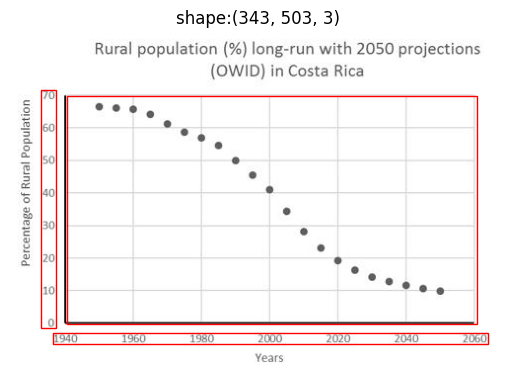

In [4]:
from matplotlib.patches import Rectangle

def plot_key_points(image, key_points):
    kp = key_points
    plt.imshow(image)
    plt.axis(False)
    for i in [0, 4, 8]:
        plt.gca().add_patch(Rectangle((kp[0+i], kp[1+i]), kp[2+i] - kp[0+i], kp[3+i] - kp[1+i], facecolor="none", ec='r', lw=1))
    plt.title(f"shape:{image.shape}")
    plt.show()

def plot_key_points_from_file(image_path, key_points):
    image = skimage.io.imread(IMAGE_PREFIX + image_path)
    return plot_key_points(image, key_points)

for i in range(1):
    plot_key_points_from_file(annotations.iloc[i].image, annotations.iloc[i].key_points)

In [5]:
IMAGE_SIZE = (128, 128)

example = annotations.iloc[100]

image = skimage.io.imread(IMAGE_PREFIX + example.image)
image = skimage.color.rgb2gray(image)
y_scale = IMAGE_SIZE[0] / image.shape[0]
x_scale = IMAGE_SIZE[1] / image.shape[1]
min_scale = min(x_scale, y_scale)
image.shape

(278, 471)

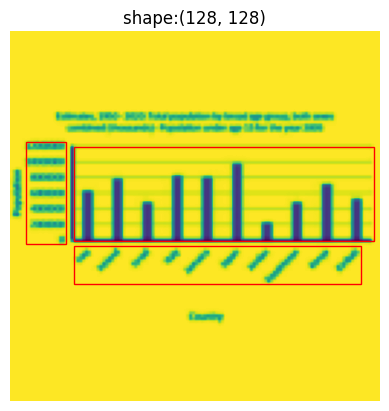

In [6]:
scaled = skimage.transform.rescale(image, min_scale)
y_offset = (IMAGE_SIZE[0] - scaled.shape[0])//2
x_offset = (IMAGE_SIZE[1] - scaled.shape[1])//2

padded = np.ones(IMAGE_SIZE)
padded[y_offset:y_offset + scaled.shape[0], x_offset: x_offset+ scaled.shape[1]] = scaled

scaled_key_points = example.key_points * min_scale
scaled_key_points += np.array([x_offset, y_offset]*6)

plot_key_points(padded, scaled_key_points)

In [7]:
annotations_train, annotations_test = train_test_split(annotations.sample(2000, random_state=123), test_size=0.2, random_state=123)
annotations_train, annotations_val = train_test_split(annotations_train, test_size=0.2, random_state=123)

In [8]:
def generate_example(example):
    image = skimage.io.imread(IMAGE_PREFIX + example.image)
    image = skimage.color.rgb2gray(image)
    image = skimage.filters.sobel(image)
    y_scale = IMAGE_SIZE[0] / image.shape[0]
    x_scale = IMAGE_SIZE[1] / image.shape[1]
    min_scale = min(x_scale, y_scale)
    scaled = skimage.transform.rescale(image, min_scale)
    y_offset = (IMAGE_SIZE[0] - scaled.shape[0])//2
    x_offset = (IMAGE_SIZE[1] - scaled.shape[1])//2

    padded = np.ones(IMAGE_SIZE)
    padded[y_offset:y_offset + scaled.shape[0], x_offset: x_offset+ scaled.shape[1]] = scaled

    scaled_key_points = example.key_points * min_scale
    scaled_key_points += np.array([x_offset, y_offset]*6)
    return padded, scaled_key_points/128

def generate_dataset(annotations):
    x, y = zip(*annotations.apply(generate_example, 1).values)
    return np.stack(x), np.stack(y)

train_x, train_y = generate_dataset(annotations_train)
val_x, val_y = generate_dataset(annotations_val)
test_x, test_y = generate_dataset(annotations_test)

1280


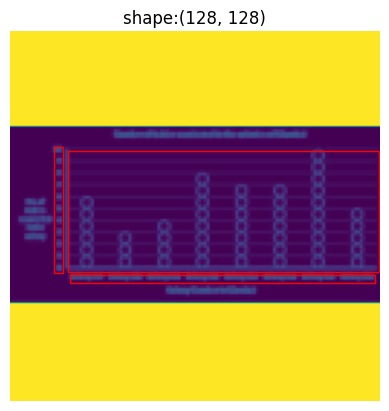

In [9]:
print(len(train_x))

for i in range(1):
    plot_key_points(train_x[i], train_y[i]*128)

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name="image", dtype="float32"
    )

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((IMAGE_SIZE[0] // 4), (IMAGE_SIZE[1] // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="linear", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)

    x = layers.Dense(32, activation="relu")(x)
    # Output layer
    x = layers.Dense(
        12, activation="sigmoid", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = x

    # Define the model
    model = keras.models.Model(
        inputs=input_img, outputs=output, name="keypoint_model_v1"
    )
    # Optimizer
    # Compile the model and return
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()

2023-03-28 21:37:04.453880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "keypoint_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 128, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 64, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 32, 64)        0         
                                                                 
 reshape (Reshape)           (None, 32, 2048)          0         
                                                                 
 dense1 (Dense)              (None, 32, 64)      

In [11]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=epochs,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping],
)

model.save("models/key_points_1.tf")

Epoch 1/100
40/40 [==============================] - 8s 181ms/step - loss: 0.0168 - mae: 0.0872 - val_loss: 0.0031 - val_mae: 0.0413
Epoch 2/100
40/40 [==============================] - 7s 179ms/step - loss: 0.0029 - mae: 0.0400 - val_loss: 0.0022 - val_mae: 0.0331
Epoch 3/100
40/40 [==============================] - 7s 180ms/step - loss: 0.0022 - mae: 0.0348 - val_loss: 0.0018 - val_mae: 0.0298
Epoch 4/100
40/40 [==============================] - 7s 182ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0015 - val_mae: 0.0261
Epoch 5/100
40/40 [==============================] - 7s 183ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.0012 - val_mae: 0.0233
Epoch 6/100
40/40 [==============================] - 7s 184ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 7/100
40/40 [==============================] - 7s 181ms/step - loss: 9.9591e-04 - mae: 0.0230 - val_loss: 9.1978e-04 - val_mae: 0.0204
Epoch 8/100
40/40 [==============================] - 7s 183ms

2023-03-28 21:49:49.603754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,64]
	 [[{{node inputs}}]]
2023-03-28 21:49:49.614051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,2048]
	 [[{{node inputs}}]]
2023-03-28 21:49:49.624240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,64]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: models/key_points_1.tf/assets


INFO:tensorflow:Assets written to: models/key_points_1.tf/assets


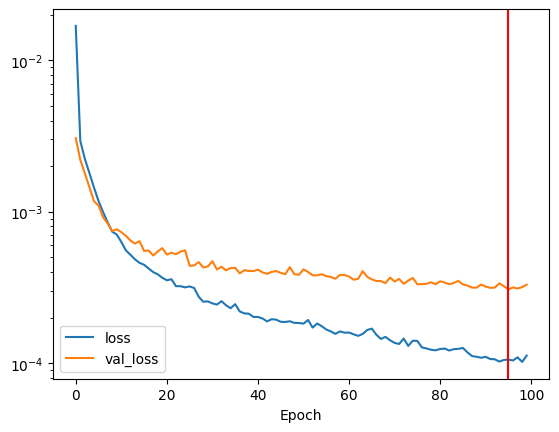

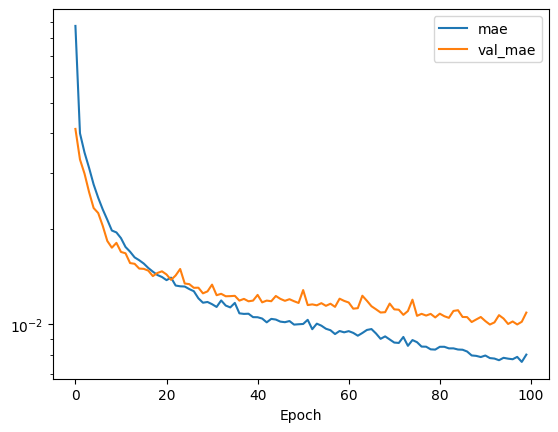

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.axvline(x=np.argmin(history.history['val_loss']), c='r')
plt.xlabel("Epoch")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel("Epoch")
plt.yscale("log")
plt.legend()
plt.show()

13/13 [==============================] - 1s 60ms/step


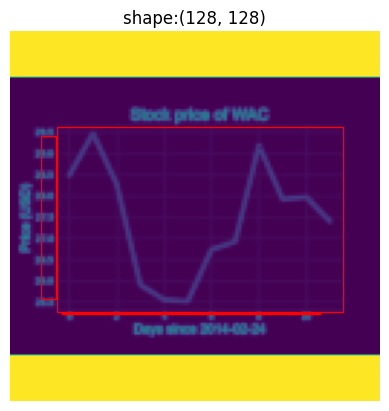

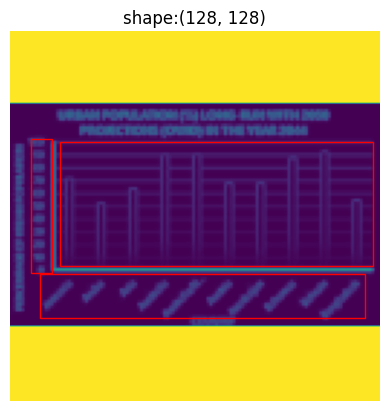

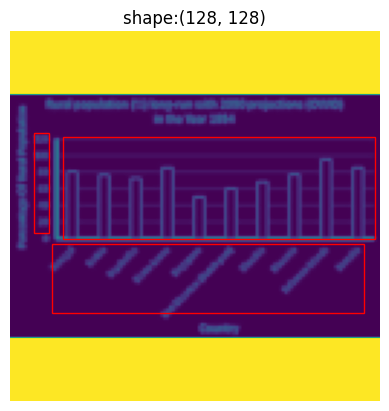

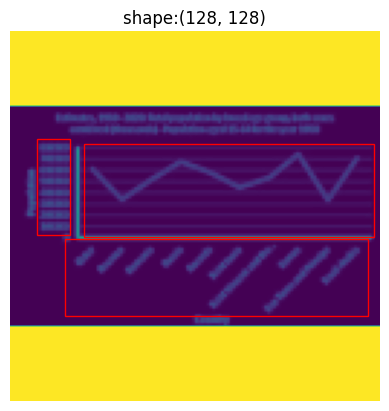

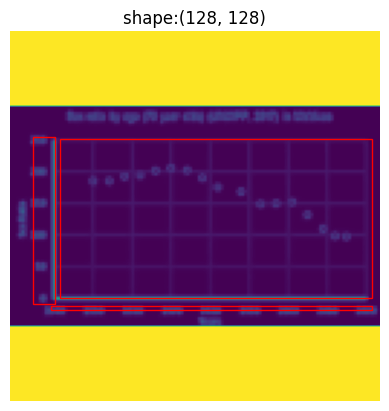

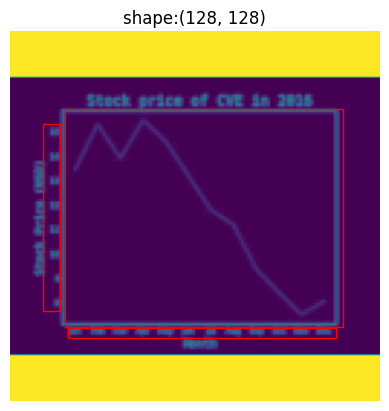

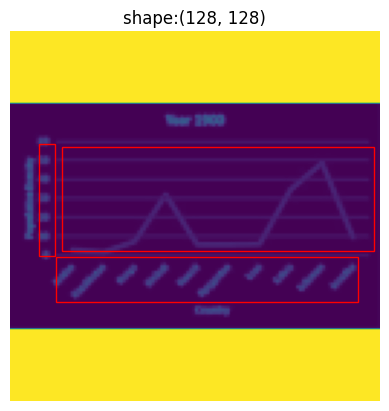

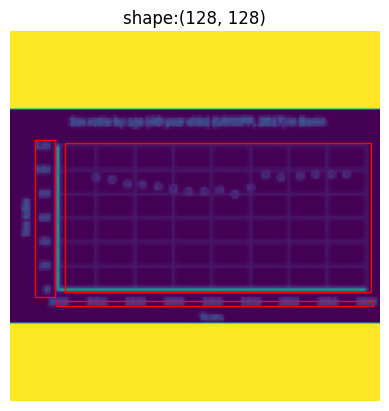

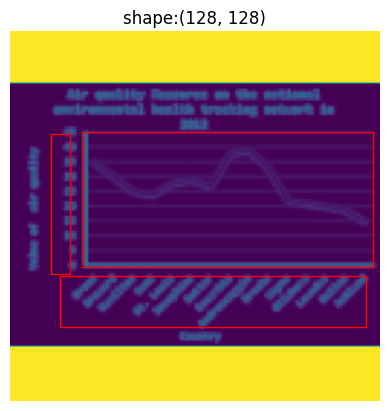

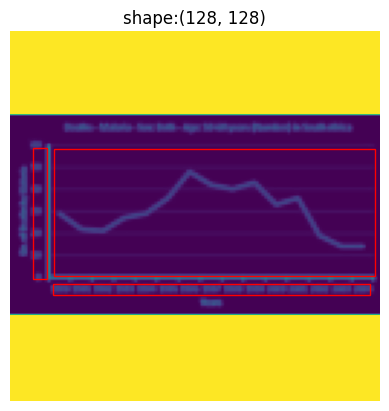

In [13]:
pred_y = model.predict(test_x)
for i in range(10):
    plot_key_points(test_x[i], pred_y[i]*128)